In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

from pymoo.factory import get_performance_indicator
from testsuite.utilities import Pareto_split, get_target_igd_refpoints
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from testsuite import directed_optimisers 
from pymoo.factory import get_performance_indicator
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
import inspect

In [3]:
from generate_queue import dmvs 

In [4]:
def get_target_from_str(string):
    ind = string.find('[')
    tstring = string[ind+1:-1]
    for target in targets:
        str_t = str(target).replace('.', 'p').replace(' ', '_')
        if tstring == str_t:
            return target

In [5]:
def load_result(directory):
    result = load_all(directory, trailing_text = "_results.pkl")
    name = get_name_from_dir(directory)
    result['name'] = name
    return result

def get_name_from_dir(dir_string):
    bits = dir_string.split('_')
    name = [bit for bit in bits if bit.lower() in OPTIMISER_NAMES]
    if type(name) is list:
        name = name[0]
    if 'ei' in bits:
        name+='_ei'
    elif 'mean' in bits:
        name+='_$\mu$'
    return name

In [6]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [7]:
OPTIMISER_NAMES = [cls[0].lower() for cls in inspect.getmembers(directed_optimisers, inspect.isclass)
        if cls[1].__module__ == 'testsuite.directed_optimisers' or cls[1].__module__ == 'testsuite.directedoptimisers']

In [8]:
OPTIMISER_NAMES

['directedsaf', 'dmvector']

In [9]:
problem_path = './'

In [10]:
# load all results from directory tree
result_dirs = sorted(os.listdir(os.path.join(problem_path, "log_data/")))
result_dirs = [r for r in result_dirs if r != '.ipynb_checkpoints']
results= []
for directory in result_dirs:
    file_path = os.path.join(problem_path, 'log_data/',  directory) 
    result = load_result(file_path)
    results.append(result)
result_dirs

['OF_WFG5__opt_DmVector__ninit_10__surrogate_MultiSurrogateGP__ei_False__dmv_0p37_0p93',
 'OF_WFG5__opt_DmVector__ninit_10__surrogate_MultiSurrogateGP__ei_False__dmv_0p83_0p55']

In [11]:
dmv0 = results[0]['dmv'][0]
dmv1 = results[1]['dmv'][0]

In [12]:
p = np.load('../../../undirected/igd_refpoints/problem_refpoints/data/wfg_elipse_2d_refpoints')
p.shape

(5000, 2)

In [13]:
def _ssd_from_vector(x, V):
    """
    Find the sum of squared distances from the
    ray defined by x to the points in V

    Parameters
    ----------
    x : ndarray, shape (d,)
        Point defining a ray from the origin

    V : ndarray, shape (M, d)
        Rows of V define the points

    Returns
    -------

    S : float
        The sum of squared distances from the ray to V
    """
    if x.ndim > 1:
        x = x.reshape(-1)
    assert V.shape[1] == x.shape[0]
    xhat = x / np.linalg.norm(x)

    S = 0
    for v in V:
        lenv = np.linalg.norm(v)
        vhat = v / lenv
        cs = vhat @ xhat
        S += np.sqrt(1 - cs * cs) * lenv
    return S

In [15]:
def extract_target(rs, p):
    dmv = rs['dmv'][0].reshape(1,-1)
    
    tpd = [_ssd_from_vector(x.reshape(1, -1), dmv) for x in p]
    target = p[np.argmin(tpd)]
    return target

def get_performance(rs, target, limit=None):
    if limit != None:
        limit = min(len(rs['y']), limit)
    else:
        limit = len(rs['y'])
    ans = np.zeros((limit, 139))
    for i, ry in enumerate(rs['y'][:limit]):
        tmp = np.array([np.min(np.linalg.norm(ry[10:j]-target, axis=1)) for j in range(11, 150)])
        ans[i, :] = tmp
    return ans

In [16]:
def plot_performance(ans, ax, c):
    for a in ans:
        ax.plot(a, c=c, alpha=0.2)
    ax.plot(ans.mean(axis=0), c=c, alpha=1.)
    ax.axhline(0., c="r", linestyle='--')

In [17]:
ref_results_dir = os.path.join(rootpath.detect(), 'experiments/undirected/data/wfg5_2obj_6dim/log_data/WFG5_Saf_init10_MultiSurrogate_mean/')
ref_results_dir

'/home/finley/phd/code/testsuite/experiments/undirected/data/wfg5_2obj_6dim/log_data/WFG5_Saf_init10_MultiSurrogate_mean/'

In [19]:
ref_results = load_all(ref_results_dir, trailing_text = "_results.pkl")

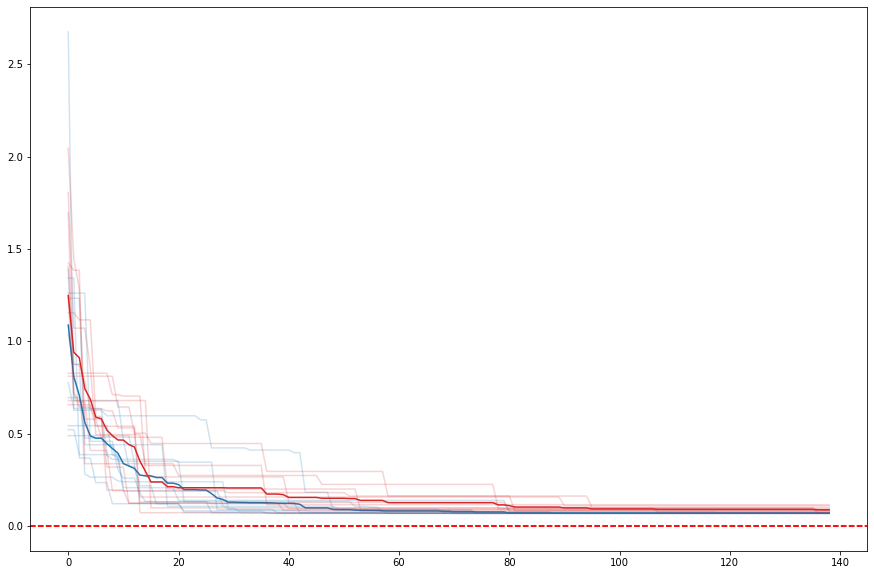

In [20]:
rs = results[0]
target = extract_target(rs, p)
ans0 = get_performance(rs, target)

ansref = get_performance(ref_results, target, limit=11)


fig = plt.figure(figsize=[15, 10])
ax = fig.gca()
plot_performance(ans0, ax, c="C0")
plot_performance(ansref, ax, c="C3")

In [21]:
pp= Pareto_split(results[0]['y'][2])[0]

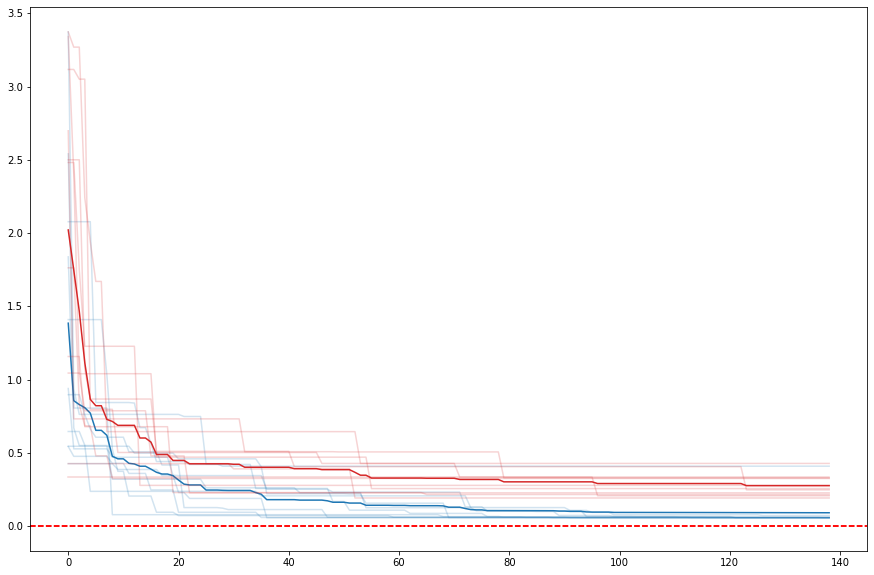

In [23]:
rs = results[1]
target = extract_target(rs, p)
ans1 = get_performance(rs, target)

ansref = get_performance(ref_results, target, limit=11)

fig = plt.figure(figsize=[15, 10])
ax = fig.gca()
plot_performance(ans1, ax, c="C0")
plot_performance(ansref, ax, c="C3")

(3.0, 4.1)

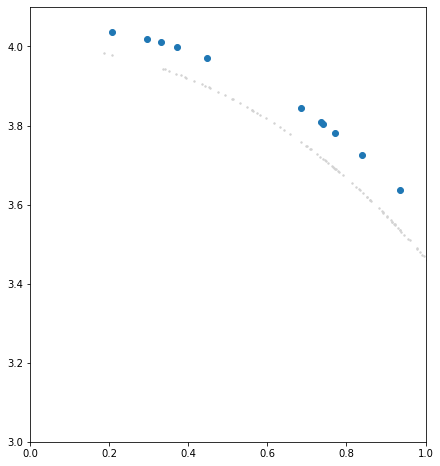

In [24]:
fig = plt.figure(figsize=[8,8])
ax = fig.gca()

ax.scatter(*pp.T, c="C0")
ax.scatter(*y.T, c="lightgrey", s=2)
ax.axis('scaled')
ax.set_xlim([0., 1.])
ax.set_ylim([3., 4.1])

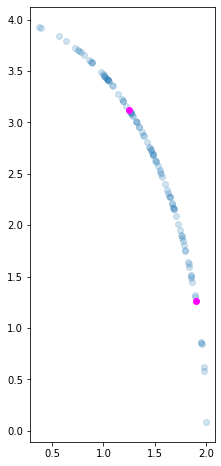

In [25]:
from problem_setup import y
fig = plt.figure(figsize=[8., 8.])
ax = fig.gca()
ax.scatter(*y[::5].T, c="C0", alpha=0.2)
ax.axis('scaled')

target0 = extract_target(results[0], p).reshape(1, -1)
target1 = extract_target(results[1], p).reshape(1, -1)

ax.scatter(*target0.T, c="magenta")
ax.scatter(*target1.T, c="magenta")